In [1]:
import torch
import torchvision.transforms as transforms
from utils.data.cornell_sal import CornellSalDataset

from models.common import post_process_output
from utils.dataset_processing import evaluation, grasp
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

data = CornellSalDataset('/media/will/research/cornell/images', 'annotations/coco.json', include_depth=False, include_rgb=True, train=True, transform=transform)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


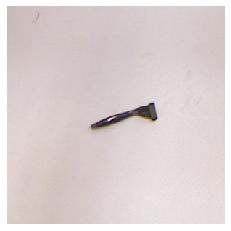

In [3]:
im = data[0][0].numpy().transpose((1,2,0))
plt.imshow(im)
plt.axis('off')
plt.show()

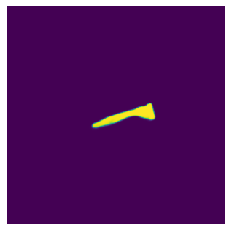

In [5]:
sal = data[0][1].squeeze().numpy()
plt.imshow(sal)
plt.axis('off')
plt.show()

In [6]:
from models.salgrasp import SGCNN

device = torch.device('cuda:0')

#model = SGCNN()
model = torch.load('/media/will/research/mtgrasp/output/models/Saliency_mt/200501_1142_typicalloss/epoch_25_iou_0.41_maxf_0.73')
model = model.to(device)
model.eval()

/home/will/anaconda3/envs/torch/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.salgrasp.SGCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


SGCNN(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convt1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt2): ConvTranspose2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (convt3): ConvTranspose2d(16, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3), output_padding=(1, 1))
  (pos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (cos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (sin_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (width_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (convt4): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt5): ConvTranspose2d(8, 16, kernel_size=(5, 5), stride=(2, 2

(-0.5, 299.5, 299.5, -0.5)

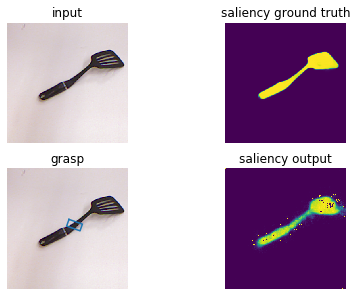

In [14]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
i=6
output = model(data[i][0].unsqueeze(0).to(device))
f1_axes[0][0].imshow(data[i][0].numpy().transpose((1,2,0)))
f1_axes[0][0].set_title('input')
f1_axes[0][0].axis('off')
f1_axes[0][1].imshow(data[i][1].squeeze().numpy())
f1_axes[0][1].set_title('saliency ground truth')
f1_axes[0][1].axis('off')
q_out, ang_out, w_out = post_process_output(output[0].detach(),
                                            output[1].detach(),
                                            output[2].detach(),
                                            output[3].detach())
gs = grasp.detect_grasps(q_out, ang_out, width_img=w_out)
for g in gs:
    g.plot(f1_axes[1][0])
f1_axes[1][0].imshow(data[i][0].numpy().transpose((1,2,0)))
f1_axes[1][0].set_title('grasp')
f1_axes[1][0].axis('off')
topil = transforms.ToPILImage()
saliency = topil(output[-1].detach().squeeze().cpu())
f1_axes[1][1].imshow(saliency)
f1_axes[1][1].set_title('saliency output')
f1_axes[1][1].axis('off')